In [1]:
import numpy as np #for manipulation of large, multi-dimensional arrays and matrices
import matplotlib.pyplot as plt #for plotting
import time # timing my code
import numba #numba for speedup
%matplotlib inline


## Our functions

In [2]:
@numba.njit

def en_and_mag(matrix, nx, ny):
    '''Calculation of the initial energy and total magnetization of the lattice'''
    
    J = 1.0
    h = 0.0
    E = 0
    M = 0
    
    for i in range(nx):
        for j in range(ny):        
            s = matrix[i,j]
            E = E - J * s * ( matrix[(i-1)%nx,j] + matrix[(i+1)%nx,j] + matrix[i,(j+1)%ny] + matrix[i,(j-1)%ny]) - h * s  #initial configuration
            M = M + s
            
    return E,M   

In [3]:
@numba.njit

def monte_carlo_2D(matrix, nx, ny, T, E, M):

    J = 1.0
    h = 0.0
    
    for i in range(nx*ny):
        x = np.random.randint(0,nx) #select a random point
        y = np.random.randint(0,ny)
        
        s = matrix[x,y]
        E_1 = - J * s * ( matrix[(x-1)%nx,y] + matrix[(x+1)%nx,y] + matrix[x,(y+1)%ny] + matrix[x,(y-1)%ny]) - h * s  #initial configuration

        E_2 = - E_1 # energy of attempted new configuration
        
        DE = E_2 - E_1
        
        r = np.random.uniform(0,1) 
        
        if np.exp(-DE/T) > r:
            matrix[x,y] = -s    
            E = E + DE
            M = M - s + matrix[x,y]
        
    return E, M

## Initial configuration of the matrix (lattice) with the spins

In [4]:
nx, ny = 20, 20
matrix = 2 * np.random.randint(0, 2, size=(nx, ny)) - 1

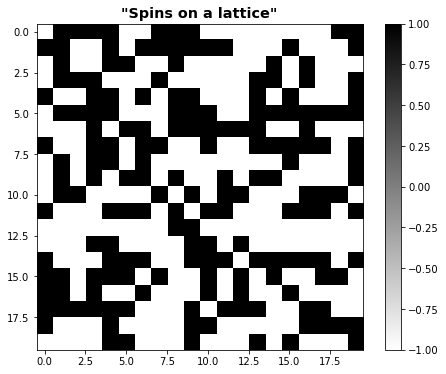

In [5]:
fig, ax = plt.subplots(figsize = [8,6]); #to create a plot

ax.set_title('"Spins on a lattice"', fontsize='x-large',fontweight='bold'); # to add a title

ax.imshow(matrix, cmap='binary'); # creating a figure of binary coloured boxes corresponding to the matrix values +1 and -1

fig.colorbar(ax.imshow(matrix, cmap='binary')); # seting a colorbar nex to the plot to show you which color correspond to which value

## Our program

En = -0.2
Mag= -0.11
time = 1.698120355606079


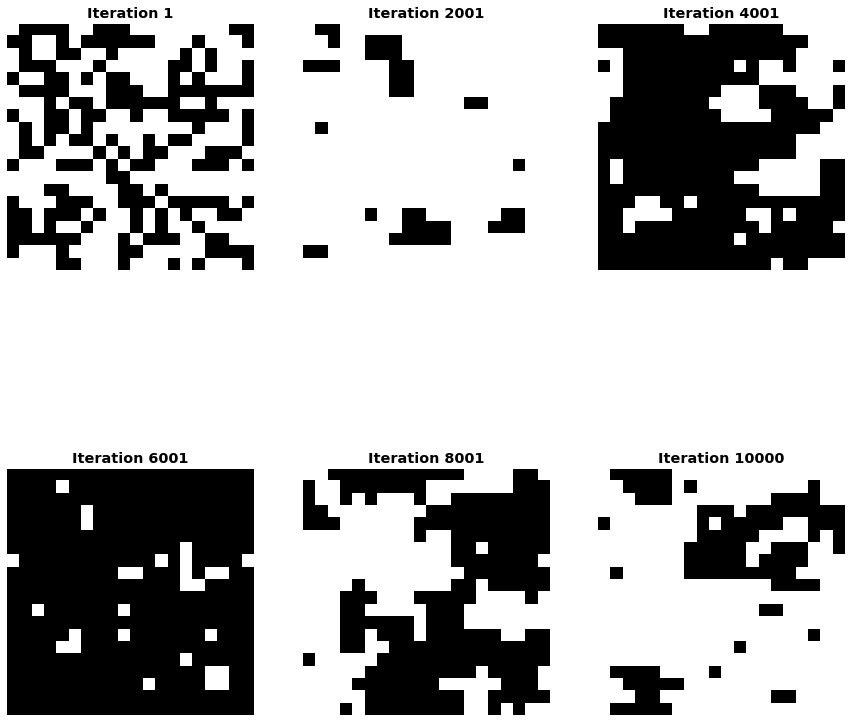

In [6]:
t1 = time.time()
T = 2.27
n_max = 10000
Energy = np.zeros(n_max)
Magnetization = np.zeros(n_max)
Energy[0], Magnetization[0] = en_and_mag(matrix, nx, ny) # calculate the energy and the total magnetization of the matrix (initial configuration of the lattice)
print('En =', Energy[0]/ (nx*ny))
print('Mag=',Magnetization[0]/ (nx*ny))

#Plot lattice configurations
figs, axes = plt.subplots(2, 3, figsize=(15, 15))
axes = np.ravel(axes)
iteration = 0
axes[iteration].axis('off')
axes[iteration].set_title(f'Iteration {1}', fontsize='x-large',fontweight='bold');
axes[iteration].imshow(matrix, cmap='binary');

#attempt spin flips with the monte carlo method and calculate the energy and the magnetization of the system
for i in range(1,n_max):
    E = Energy[i-1]
    M = Magnetization[i-1]
    Energy[i], Magnetization[i] = monte_carlo_2D(matrix, nx, ny, T, E, M)
    if i%2000 == 0  or i == n_max-1:
        iteration += 1
        axes[iteration].axis('off')
        axes[iteration].set_title(f'Iteration {i+1}', fontsize='x-large',fontweight='bold');
        axes[iteration].imshow(matrix, cmap='binary');
            
    
Energy = Energy / (nx*ny) #average energy and magnetization per spin
Magnetization = Magnetization / (nx*ny)
print('time =',time.time() - t1)

## Plotting the energy and magnetization per spin

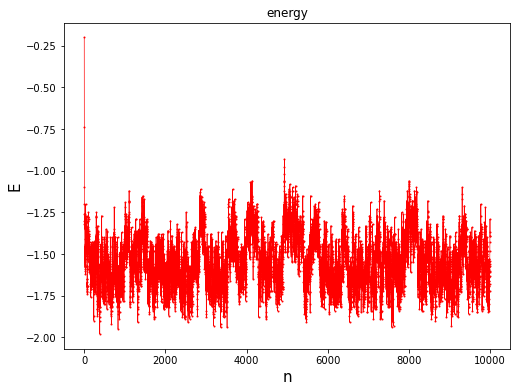

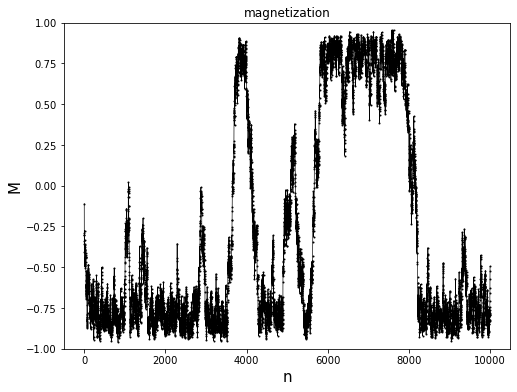

In [7]:
fig1, ax1 = plt.subplots(figsize = [8,6]);
fig2, ax2 = plt.subplots(figsize = [8,6]);

t = np.arange(n_max)

#ax1.set_ylim([-2.5,-0.5])
ax2.set_ylim([-1,1])
ax1.set_title("energy")
ax2.set_title("magnetization")
ax1.set_ylabel("E", fontsize="15")
ax1.set_xlabel("n", fontsize="15")
ax2.set_ylabel("M", fontsize="15")
ax2.set_xlabel("n", fontsize="15")

ax1.plot(t, Energy,'-or', markersize=1, linewidth=0.65);
ax2.plot(t,Magnetization,'-ok', markersize=1, linewidth=0.65);


## Energy and Magnetization for different n0

In [8]:
n0s = np.arange(0, 10000, 100)
mean_energy = []
mean_magnetization = []

for n0 in n0s:
    mean_energy.append(np.mean(Energy[n0:]))
    mean_magnetization.append(np.mean(np.abs(Magnetization[n0:])))

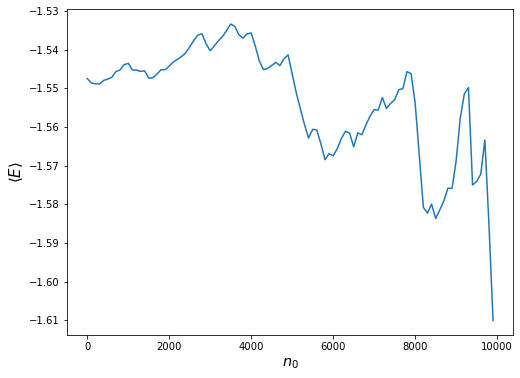

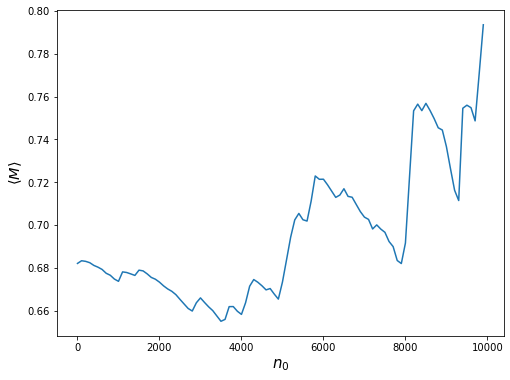

In [9]:
fig3,ax3 = plt.subplots(figsize = [8,6]);
fig4, ax4 = plt.subplots(figsize = [8,6]);

ax3.plot(n0s, mean_energy);
ax3.set_xlabel('$n_0$', fontsize='x-large');
ax3.set_ylabel('$\\langle E \\rangle$', fontsize="15");
#ax3.set_ylim([-1,.8]);
ax4.plot(n0s, mean_magnetization)
ax4.set_xlabel('$n_0$', fontsize='15')
ax4.set_ylabel('$\\langle M \\rangle$', fontsize='x-large');

#### Late starting points $n_0$ do not give trustworthy results !

## Investigate system behavior for different temperatures

Running this may take a while.

In [10]:
@numba.njit()


def monte_carlo_T(nx, ny, Ts, E, M, matrix, repetitions, n_max, n0, J, h, mag_rep_T):
    #we want to have statistics (mean and error of magnetization) after a number of repetitions
    #for different temperatures
    '''We create a 2-D array with 5 average magnetizations (rows) per temperature (columns) '''
    
    index = 0
    for T in Ts:
        #For every temperature value we want to store the absolute value of the mean magnetization 
        #of every repetition
        
        for j in range(repetitions):
            #the next 2 for loops are the same as the first part of the exercise
            total_magnetizations = 0
            for o in range(n_max):
                
                for i in range(nx*ny):
                    x = np.random.randint(0,nx) 
                    y = np.random.randint(0,ny)

                    s = matrix[x,y]
                    E_1 = - J * s * ( matrix[(x-1)%nx,y] + matrix[(x+1)%nx,y] + matrix[x,(y+1)%ny] + matrix[x,(y-1)%ny]) - h * s  #initial configuration

                    E_2 = - E_1 

                    DE = E_2 - E_1

                    r = np.random.uniform(0,1) 

                    if np.exp(-DE/T) > r:
                        matrix[x,y] = -s    
                        E = E + DE
                        M = M - s + matrix[x,y]

                if o > n0:
                    #add magnetization per site after the n0th step
                    total_magnetizations += M/(nx*ny)
                    #in order to find the average magnetization per repetition
            
            #we store the absolute average magnetization per repetition per temperature value
            mag_rep_T[j,index] = np.abs(total_magnetizations / (n_max - n0)) 
            
        
        index += 1
    
    return mag_rep_T

    


In [11]:
# values of T to test
Ts = np.linspace(0.5, 3.5, 50)
nx, ny = 20, 20
matrix = 2 * np.random.randint(0, 2, size=(nx, ny)) - 1
Energy, Magnetization = en_and_mag(matrix, nx, ny) # calculate the energy and the total magnetization of the matrix (initial configuration of the lattice)
repetitions=5
n_max=10000
n0=1000
J=1
h=0

mag_rep_T = np.zeros([repetitions,len(Ts)]) #magnetization per repetition per temperature

mag_rep_T = monte_carlo_T(nx, ny, Ts, Energy, Magnetization, matrix, repetitions, n_max, n0, J, h, mag_rep_T)
mag_mean = mag_rep_T.mean(axis=0) #mean magnetization per temperature
mag_error = mag_rep_T.std(axis=0)/np.sqrt(len(mag_rep_T[:,0])) #error of the mean

### Plot data and compare to Onsager's solution

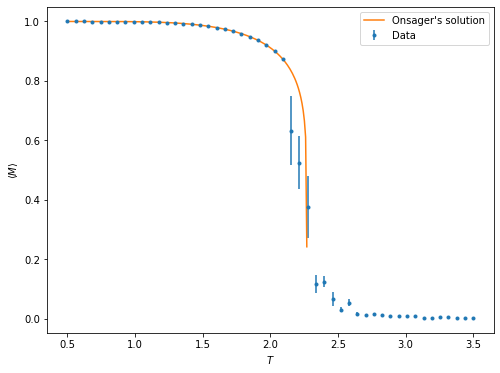

In [12]:
fig5,ax5 = plt.subplots(figsize=[8,6])
ax5.errorbar(Ts, mag_mean, yerr=mag_error, fmt='.', label='Data')

x_onsager = np.linspace(0.5, 2.26918, 200) #critical T at 2.26918
ax5.plot(x_onsager, (1 - np.sinh(2 / x_onsager) ** (-4)) ** (1/8), label='Onsager\'s solution')

ax5.set_xlabel('$T$')
ax5.set_ylabel('$\\langle M \\rangle$')
ax5.legend();

#### With better statistics (more data points, larger lattice, etc) the closer our results wil be to the Onsager's exact solution

### Repeat for finite external field h

In [13]:
# values of T to test
Ts = np.linspace(0.5, 15, 50)
nx, ny = 20, 20
matrix = 2 * np.random.randint(0, 2, size=(nx, ny)) - 1
Energy, Magnetization = en_and_mag(matrix, nx, ny) # calculate the energy and the total magnetization of the matrix (initial configuration of the lattice)
repetitions=5
n_max=10000
n0=1000
J=1
h=0.5

mag_rep_T = np.zeros([repetitions,len(Ts)]) #magnetization per repetition per temperature

mag_rep_T = monte_carlo_T(nx, ny, Ts, Energy, Magnetization, matrix, repetitions, n_max, n0, J, h, mag_rep_T)
mag_mean = mag_rep_T.mean(axis=0) #mean magnetization per temperature
mag_error = mag_rep_T.std(axis=0)/np.sqrt(len(mag_rep_T[:,0])) #error of the mean

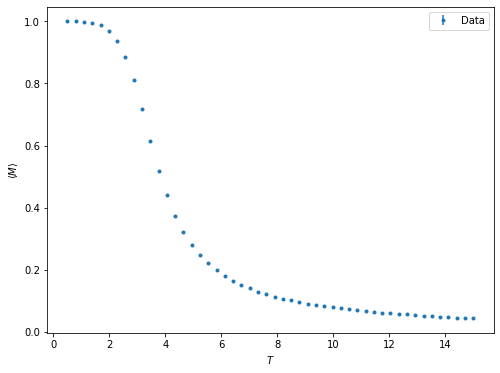

In [14]:
fig6,ax6 = plt.subplots(figsize=[8,6])
ax6.errorbar(Ts, mag_mean, yerr=mag_error, fmt='.', label='Data')


ax6.set_xlabel('$T$')
ax6.set_ylabel('$\\langle M \\rangle$')
ax6.legend();

### Lets repeat for a bigger system

In [15]:
nx, ny = 100, 100
matrix = 2 * np.random.randint(0, 2, size=(nx, ny)) - 1

En = -0.0072
Mag= -0.005
time = 5.6080896854400635


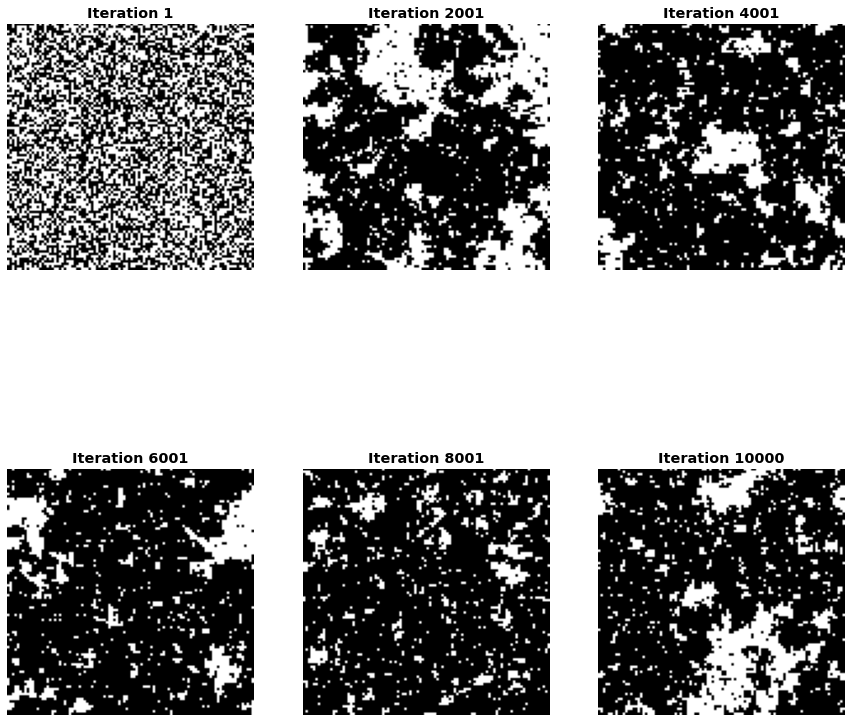

In [16]:
t1 = time.time()
T = 2.27
n_max = 10000
Energy = np.zeros(n_max)
Magnetization = np.zeros(n_max)
Energy[0], Magnetization[0] = en_and_mag(matrix, nx, ny) # calculate the energy and the total magnetization of the matrix (initial configuration of the lattice)
print('En =', Energy[0]/ (nx*ny))
print('Mag=',Magnetization[0]/ (nx*ny))

#Plot lattice configurations
figs, axes = plt.subplots(2, 3, figsize=(15, 15))
axes = np.ravel(axes)
iteration = 0
axes[iteration].axis('off')
axes[iteration].set_title(f'Iteration {1}', fontsize='x-large',fontweight='bold');
axes[iteration].imshow(matrix, cmap='binary');

#attempt spin flips with the monte carlo method and calculate the energy and the magnetization of the system
for i in range(1,n_max):
    E = Energy[i-1]
    M = Magnetization[i-1]
    Energy[i], Magnetization[i] = monte_carlo_2D(matrix, nx, ny, T, E, M)
    if i%2000 == 0  or i == n_max-1:
        iteration += 1
        axes[iteration].axis('off')
        axes[iteration].set_title(f'Iteration {i+1}', fontsize='x-large',fontweight='bold');
        axes[iteration].imshow(matrix, cmap='binary');
            
    
Energy = Energy / (nx*ny) #average energy and magnetization per spin
Magnetization = Magnetization / (nx*ny)
print('time =',time.time() - t1)

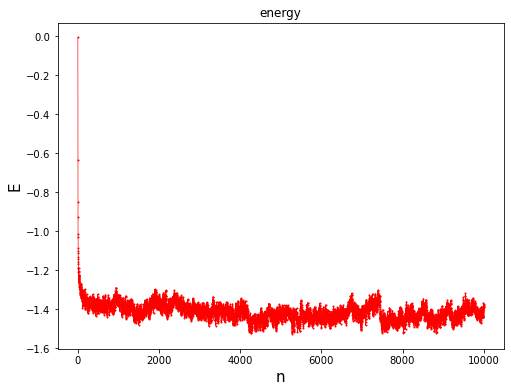

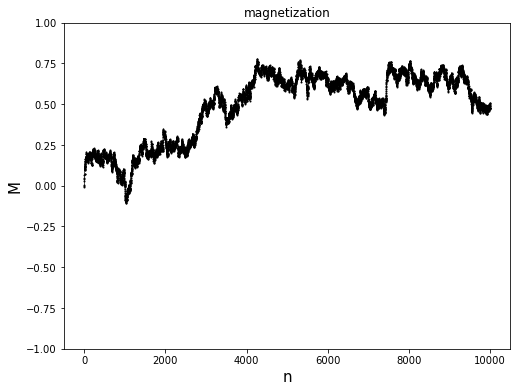

In [17]:
fig7, ax7 = plt.subplots(figsize = [8,6]);
fig8, ax8 = plt.subplots(figsize = [8,6]);

t = np.arange(n_max)


ax8.set_ylim([-1,1])
ax7.set_title("energy")
ax8.set_title("magnetization")
ax7.set_ylabel("E", fontsize="15")
ax7.set_xlabel("n", fontsize="15")
ax8.set_ylabel("M", fontsize="15")
ax8.set_xlabel("n", fontsize="15")

ax7.plot(t, Energy,'-or', markersize=1, linewidth=0.65);
ax8.plot(t,Magnetization,'-ok', markersize=1, linewidth=0.65);


In [18]:
n0s = np.arange(0, 10000, 100)
mean_energy = []
mean_magnetization = []

for n0 in n0s:
    mean_energy.append(np.mean(Energy[n0:]))
    mean_magnetization.append(np.mean(np.abs(Magnetization[n0:])))

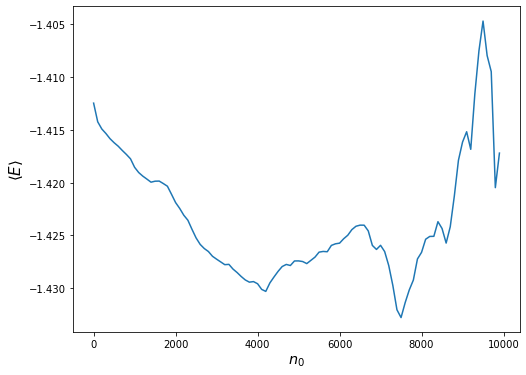

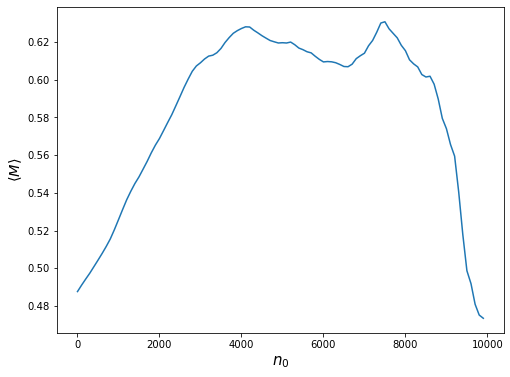

In [19]:
fig9,ax9 = plt.subplots(figsize = [8,6]);
fig10, ax10 = plt.subplots(figsize = [8,6]);

ax9.plot(n0s, mean_energy);
ax9.set_xlabel('$n_0$', fontsize='x-large');
ax9.set_ylabel('$\\langle E \\rangle$', fontsize="15");
#ax9.set_ylim([-1,.8]);
ax10.plot(n0s, mean_magnetization)
ax10.set_xlabel('$n_0$', fontsize='15')
ax10.set_ylabel('$\\langle M \\rangle$', fontsize='x-large');

In [20]:
# values of T to test
Ts = np.linspace(0.5, 3.5, 20)
nx, ny = 100, 100
matrix = 2 * np.random.randint(0, 2, size=(nx, ny)) - 1
Energy, Magnetization = en_and_mag(matrix, nx, ny) # calculate the energy and the total magnetization of the matrix (initial configuration of the lattice)
repetitions=5
n_max=10000
n0=1000
J=1
h=0

mag_rep_T = np.zeros([repetitions,len(Ts)]) #magnetization per repetition per temperature

mag_rep_T = monte_carlo_T(nx, ny, Ts, Energy, Magnetization, matrix, repetitions, n_max, n0, J, h, mag_rep_T)
mag_mean = mag_rep_T.mean(axis=0) #mean magnetization per temperature
mag_error = mag_rep_T.std(axis=0)/np.sqrt(len(mag_rep_T[:,0])) #error of the mean

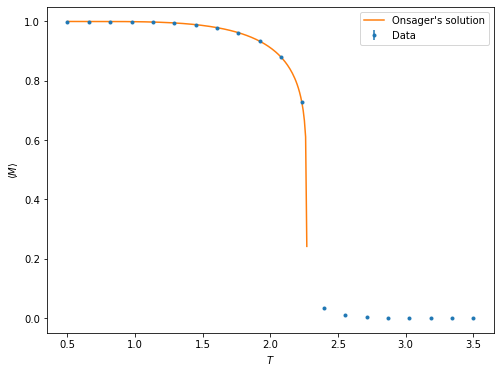

In [21]:
fig11,ax11 = plt.subplots(figsize=[8,6])
ax11.errorbar(Ts, mag_mean, yerr=mag_error, fmt='.', label='Data')

x_onsager = np.linspace(0.5, 2.26918, 200) #critical T at 2.26918
ax11.plot(x_onsager, (1 - np.sinh(2 / x_onsager) ** (-4)) ** (1/8), label='Onsager\'s solution')

ax11.set_xlabel('$T$')
ax11.set_ylabel('$\\langle M \\rangle$')
ax11.legend();

In [22]:
# values of T to test
Ts = np.linspace(0.5, 15, 20)
nx, ny = 100, 100
matrix = 2 * np.random.randint(0, 2, size=(nx, ny)) - 1
Energy, Magnetization = en_and_mag(matrix, nx, ny) # calculate the energy and the total magnetization of the matrix (initial configuration of the lattice)
repetitions=5
n_max=10000
n0=1000
J=1
h=0.5

mag_rep_T = np.zeros([repetitions,len(Ts)]) #magnetization per repetition per temperature

mag_rep_T = monte_carlo_T(nx, ny, Ts, Energy, Magnetization, matrix, repetitions, n_max, n0, J, h, mag_rep_T)
mag_mean = mag_rep_T.mean(axis=0) #mean magnetization per temperature
mag_error = mag_rep_T.std(axis=0)/np.sqrt(len(mag_rep_T[:,0])) #error of the mean

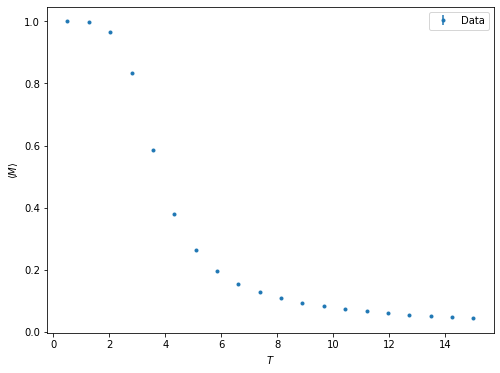

In [23]:
fig12,ax12 = plt.subplots(figsize=[8,6])
ax12.errorbar(Ts, mag_mean, yerr=mag_error, fmt='.', label='Data')


ax12.set_xlabel('$T$')
ax12.set_ylabel('$\\langle M \\rangle$')
ax12.legend();

### Even higher resolution

En = 0.000392
Mag= -0.00109


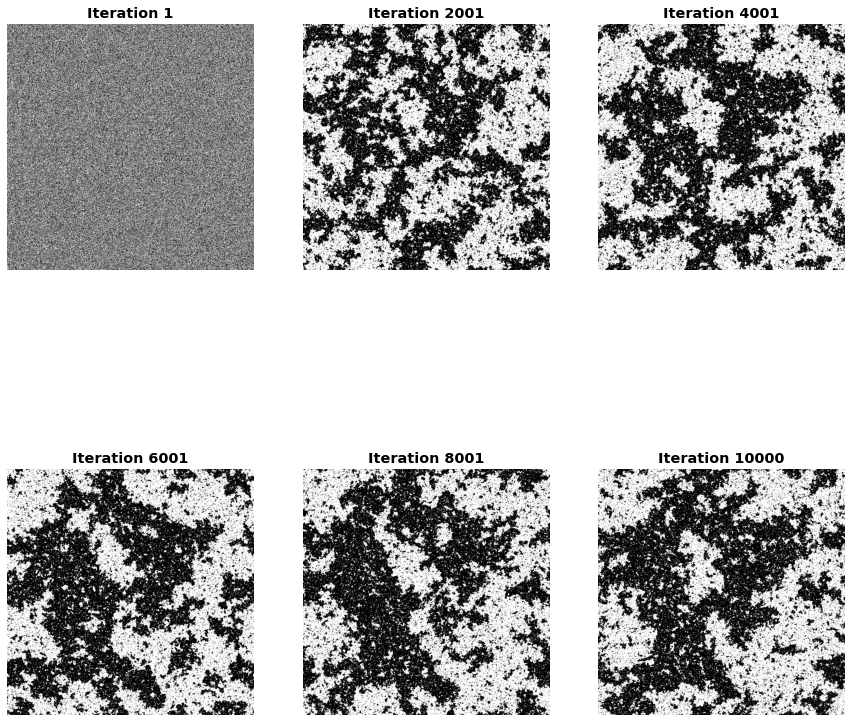

In [24]:
nx, ny = 1000, 1000
matrix = 2 * np.random.randint(0, 2, size=(nx, ny)) - 1
T = 2.27
n_max = 10000
Energy = np.zeros(n_max)
Magnetization = np.zeros(n_max)
Energy[0], Magnetization[0] = en_and_mag(matrix, nx, ny) # calculate the energy and the total magnetization of the matrix (initial configuration of the lattice)
print('En =', Energy[0]/ (nx*ny))
print('Mag=',Magnetization[0]/ (nx*ny))

#Plot lattice configurations
figs, axes = plt.subplots(2, 3, figsize=(15, 15))
axes = np.ravel(axes)
iteration = 0
axes[iteration].axis('off')
axes[iteration].set_title(f'Iteration {1}', fontsize='x-large',fontweight='bold');
axes[iteration].imshow(matrix, cmap='binary');

#attempt spin flips with the monte carlo method and calculate the energy and the magnetization of the system
for i in range(1,n_max):
    E = Energy[i-1]
    M = Magnetization[i-1]
    Energy[i], Magnetization[i] = monte_carlo_2D(matrix, nx, ny, T, E, M)
    if i%2000 == 0  or i == n_max-1:
        iteration += 1
        axes[iteration].axis('off')
        axes[iteration].set_title(f'Iteration {i+1}', fontsize='x-large',fontweight='bold');
        axes[iteration].imshow(matrix, cmap='binary');
            
    
Energy = Energy / (nx*ny) #average energy and magnetization per spin
Magnetization = Magnetization / (nx*ny)

### At the critical temperature, clusters are scale-free

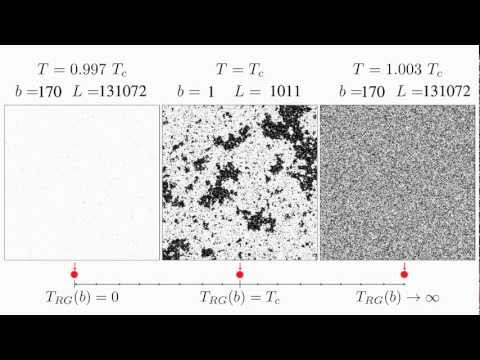

In [25]:
from IPython.display import YouTubeVideo
YouTubeVideo('MxRddFrEnPc', width=800, height=600)